In [1]:
import numpy as np
import pandas as pd
import os
import requests
import matplotlib.pyplot as plt

import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [2]:
# Set up folder with data:
os.chdir('D:\\01_PROJECTS_sripts_code\\Electricty_Demand\\02_FORECAST')

In [3]:
#%% Function to extract code from GitHub:
def GetGitHubCode(GitUrl):

    response = requests.get(GitUrl) #get data from json file located at specified URL 

    if response.status_code == requests.codes.ok:
        contentOfUrl = response.content
        exec(contentOfUrl, globals() )
    else:
        print('Content was not found.')

In [4]:
# Download functions from GitHub:
GitUrl__Prepare_Data_For_Regression = 'https://raw.githubusercontent.com/kamilbanas85/Phyton_usefull_functions/main/Prepare_Data_For_Regression.py'
GetGitHubCode(GitUrl__Prepare_Data_For_Regression)

GitUrl__Make_TS_Regression = 'https://raw.githubusercontent.com/kamilbanas85/Phyton_usefull_functions/main/Make_TS_Regression.py'
GetGitHubCode(GitUrl__Make_TS_Regression)

GitUrl__Goodness_Of_Fit = 'https://raw.githubusercontent.com/kamilbanas85/Phyton_usefull_functions/main/Goodness_Of_Fit.py'
GetGitHubCode(GitUrl__Goodness_Of_Fit)

GitUrl__Multicollinearity_Check_Functions = 'https://raw.githubusercontent.com/kamilbanas85/Phyton_usefull_functions/main/Multicollinearity_Check_Functions.py'
GetGitHubCode(GitUrl__Multicollinearity_Check_Functions)

GitUrl__Feature_Selection = 'https://raw.githubusercontent.com/kamilbanas85/Phyton_usefull_functions/main/Feature_Selection.py'
GetGitHubCode(GitUrl__Feature_Selection)

GitUrl__ANN_Keras_functions = 'https://raw.githubusercontent.com/kamilbanas85/Phyton_usefull_functions/main/ANN_Keras_functions.py'
GetGitHubCode(GitUrl__ANN_Keras_functions)

In [5]:
# Read Analysis Data:
AnalysisData = pd.read_csv('AnalysisDF.csv',
                           parse_dates =['Date'],
                           index_col = 'Date')

AnalysisData.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 63552 entries, 2015-07-01 01:00:00 to 2022-09-30 00:00:00
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Demand               63552 non-null  float64
 1   air_temperature      63552 non-null  float64
 2   humidity             63552 non-null  float64
 3   sky_cover            63552 non-null  float64
 4   wind_speed           63552 non-null  float64
 5   Population           63552 non-null  float64
 6   RealGDP              63552 non-null  float64
 7   DallasFedManufIndex  63552 non-null  float64
 8   WorkDay              63552 non-null  int64  
 9   hour                 63552 non-null  int64  
 10  day                  63552 non-null  int64  
 11  week                 63552 non-null  int64  
 12  month                63552 non-null  int64  
 13  HDD                  63552 non-null  int64  
 14  CDD                  63552 non-null  int64  
dtypes

In [6]:
##########################################################
##########################################################
#%% Prepare data
##########################################################
##########################################################

In [7]:
# Select Main Data
Dependent_Var = 'Demand'

Independent_Vars = ['HDD',
                    'CDD',
                    'wind_speed',
                    'humidity',
                    'sky_cover',
#                   'Population',
                    'RealGDP',
                    'DallasFedManufIndex',
                    'WorkDay',
                    'hour',
#                   'day',
                    'week'
#                   'month'
                   ]

DummyForColumn = None
LagList = None

In [8]:
### Cut data to pre-Covid time and crate 2 datasets to show diffrence between a summer and winter predictions

In [9]:
###################
#%% '01' model on summer time
###################

In [10]:
AnalysisData_01 = AnalysisData.loc[:'2019-07']   

In [11]:
TestSetDate_01 = '2019-02'

In [12]:
# Prepare Data 
X_01, y_01 =  DevideOnXandY_CreateDummies(AnalysisData_01, 
                                          DependentVar = Dependent_Var,
                                          IndependentVar = Independent_Vars,
                                          DummyForCol = DummyForColumn,
                                          drop_first = False)

X_Train_01, y_Train_01,\
X_Test_01, y_Test_01 = \
            PrepareDataForRegression(X_01, y_01, 
                                     TestSplitInd = TestSetDate_01,
                                     ValSplitInd = None,     
                                     ScalerType = None,
                                     ScalerRange = (0,1),                             
                                     BatchSize = None,
                                     WindowLength = 1)

In [13]:
###################
#%% '02' model on winter time
###################

In [14]:
AnalysisData_02 = AnalysisData.loc[:'2020-02']

In [15]:
TestSetDate_02 = '2019-09'

In [16]:
# Prepare Data for ANN
X_02, y_02 =  DevideOnXandY_CreateDummies(AnalysisData_02, 
                                          DependentVar = Dependent_Var,
                                          IndependentVar = Independent_Vars,
                                          DummyForCol = DummyForColumn,
                                          drop_first = False)

X_Train_02, y_Train_02,\
X_Test_02, y_Test_02 = \
            PrepareDataForRegression(X_02, y_02, 
                                     TestSplitInd = TestSetDate_02,
                                     ValSplitInd = None,     
                                     ScalerType = None,
                                     ScalerRange = (0,1),                             
                                     BatchSize = None,
                                     WindowLength = 1)

In [17]:
##########################################################
##########################################################
#%% FIT MODEL - hyperparameter tuning
##########################################################
##########################################################

In [18]:
# hyperparameters grid
gbm_param_grid = {
                  'n_estimators': [100, 150, 175, 200, 225],
                  'max_depth': range(2, 6),
                  'subsample': [0.5, 0.6, 0.7, 0.8, 0.9],
                  'colsample_bytree': [0.5, 0.7, 0.9],
                  'learning_rate': [0.005, 0.01, 0.05, 0.1],
                  'gamma': [0, 0.25, 0.5, 1.0],
                  'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
                  'min_child_weight':[1, 5, 15, 25, 50]
                 }

In [19]:
###################
#%% '01' model on summer time
###################

In [20]:
# Instantiate the regressor: gbm
gbm = xgb.XGBRegressor()

# Perform random search with CV for time series
GXBmodel_RandomSearch_01 = RandomizedSearchCV(param_distributions = gbm_param_grid,
                                              estimator = gbm,
                                              scoring = "neg_mean_squared_error",
                                              n_iter = 50,
                                              cv = TimeSeriesSplit(n_splits=8).split(X_Train_01),
                                              verbose=1,
                                              n_jobs=-1)

## in case of GridSeach:  param_grid no param_distributions

# Fit randomized_mse to the data
GXBmodel_RandomSearch_01.fit(X_Train_01, y_Train_01)

# Print the best parameters
print("Best parameters found: ", GXBmodel_RandomSearch_01.best_params_)

Fitting 8 folds for each of 50 candidates, totalling 400 fits
Best parameters found:  {'subsample': 0.7, 'reg_lambda': 1.0, 'n_estimators': 225, 'min_child_weight': 25, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.25, 'colsample_bytree': 0.7}


In [21]:
# Extract the best model
Final_Model_01 = GXBmodel_RandomSearch_01.best_estimator_

In [22]:
###################
#%% '02' model on winter time
###################

In [23]:
# Train model on new dataset
Final_Model_02 = xgb.XGBRegressor()
Final_Model_02.set_params(**GXBmodel_RandomSearch_01.best_params_)
Final_Model_02.fit(X_Train_02, y_Train_02)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.25, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=3, max_leaves=0, min_child_weight=25, missing=nan,
             monotone_constraints='()', n_estimators=225, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [24]:
##########################################################
##########################################################
#%% Check Model - Test Set
##########################################################
##########################################################

In [25]:
###################
#%% test '01' model on summer time
###################

In [26]:
#%% Make Forecast - Test Set
yhat_Test_XGboost_01, X_Test_XGboost_01 = \
    MakeTSforecast(X_Test_01,\
                   Model = Final_Model_01,\
                   DependentVar = Dependent_Var,\
                   Intecept = False,\
                   LagsList = LagList,\
                   Scaler_y = None,\
                   Scaler_X = None,\
                   Test_or_Forecast = 'Test')

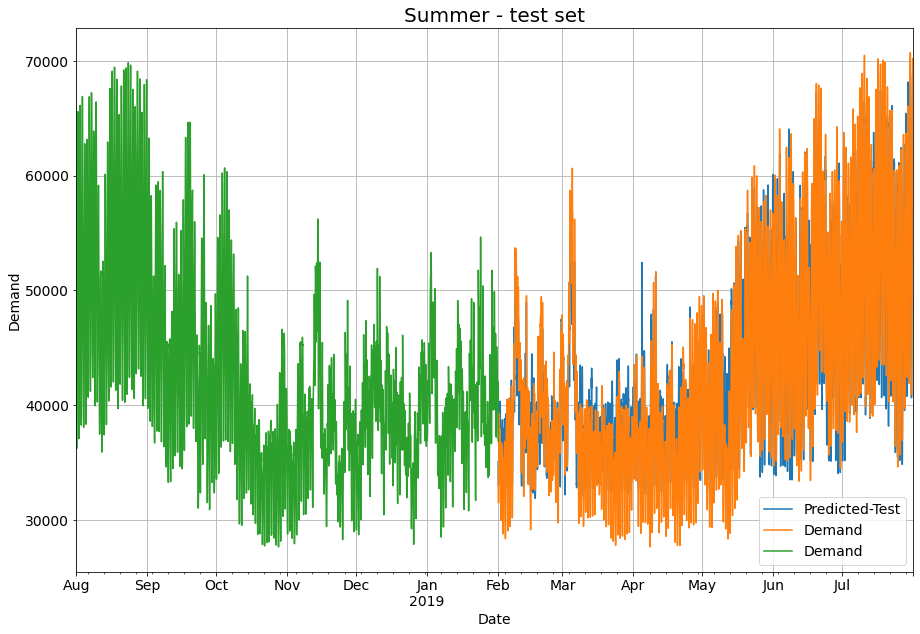

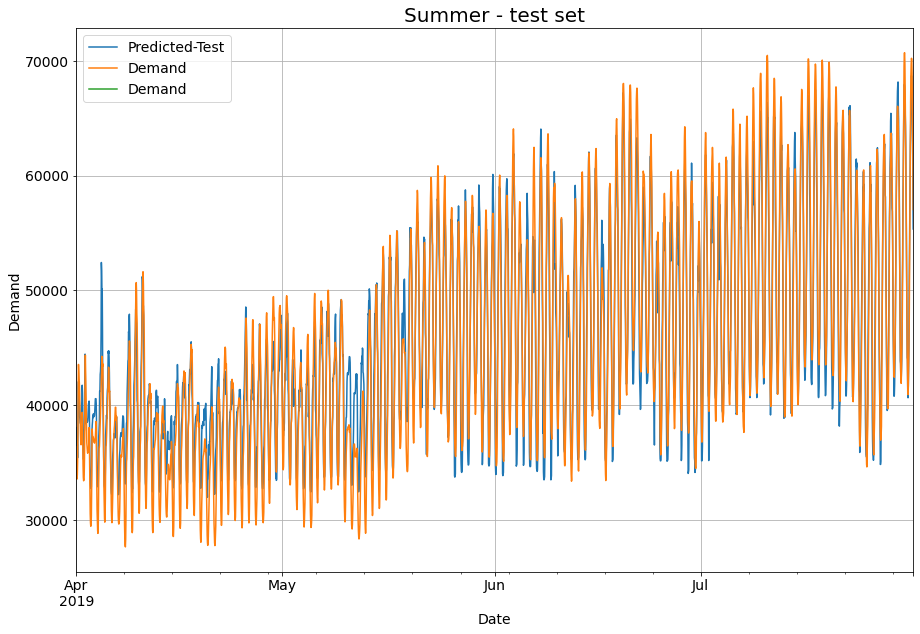

In [28]:
# Plot Fitted Data
pd.concat([ yhat_Test_XGboost_01 ,
            y_Test_01,
            y_Train_01 ], axis = 1).loc['2018-08':].plot()     

        

plt.ylabel('Demand', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Summer - test set', fontsize=20)
plt.legend(fontsize=14)
plt.grid()
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()



pd.concat([ yhat_Test_XGboost_01 ,
            y_Test_01,
            y_Train_01 ], axis = 1).loc['2019-04':].plot()

plt.ylabel('Demand', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Summer - test set', fontsize=20)
plt.legend(fontsize=14)
plt.grid()
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()

In [29]:
print( CalculateR2andR2adj(y_Test_01, yhat_Test_XGboost_01, X_Test_01, const = False) )
print('')
print( f'MAE:  {round(mean_absolute_error(y_Test_01, yhat_Test_XGboost_01),2)}'  )
print( f'MAPE: {round(mean_absolute_percentage_error(y_Test_01, yhat_Test_XGboost_01)*100,2)}' )
print( f'RSME: {round(np.sqrt(mean_squared_error(y_Test_01, yhat_Test_XGboost_01)),2)}' )

R2: 0.9301
R2_adj: 0.9299
(0.9301, 0.9299)

MAE:  2031.1
MAPE: 5.03
RSME: 2491.36


In [30]:
###################
#%% test '02' model on  winter time
###################

In [31]:
yhat_Test_XGboost_02, X_Test_XGboost_02 = \
    MakeTSforecast(X_Test_02,\
                   Model = Final_Model_02,\
                   DependentVar = Dependent_Var,\
                   Intecept = False,\
                   LagsList = LagList,\
                   Scaler_y = None,\
                   Scaler_X = None,\
                   Test_or_Forecast = 'Test')

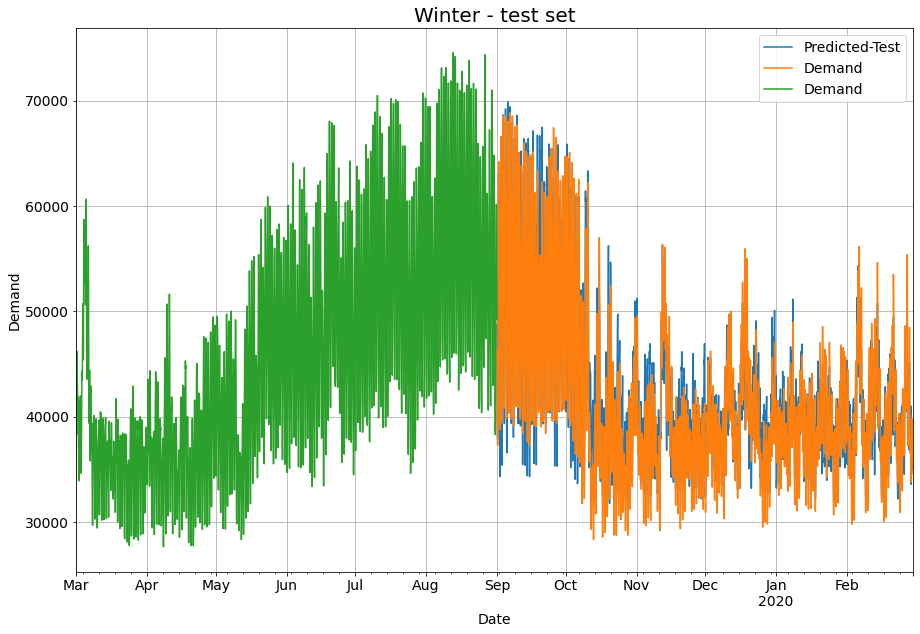

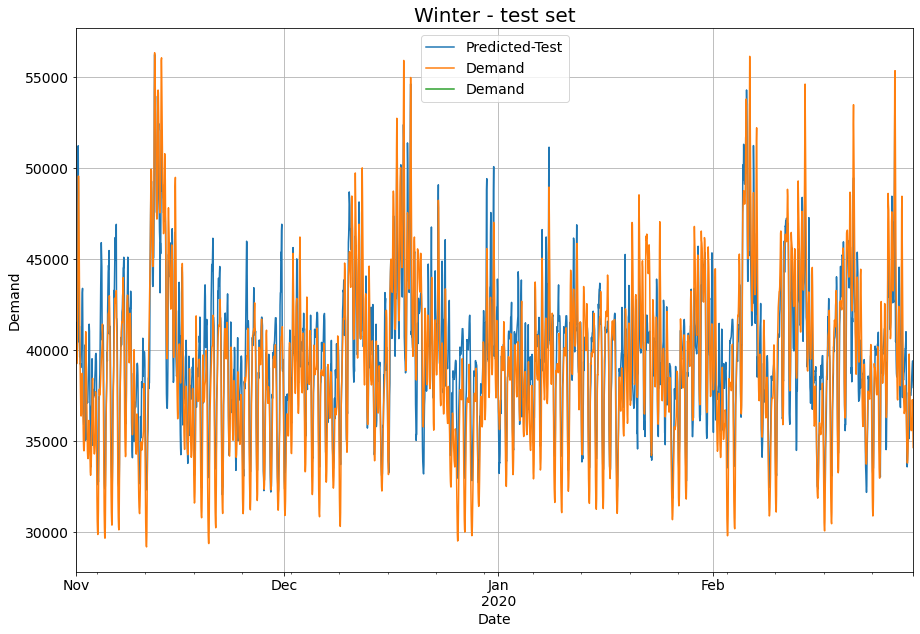

In [32]:
# Plot Fitted Data
pd.concat([ yhat_Test_XGboost_02 ,
            y_Test_02,
            y_Train_02 ], axis = 1).loc['2019-03':].plot()       
        

plt.ylabel('Demand', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Winter - test set', fontsize=20)
plt.legend(fontsize=14)
plt.grid()
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()



pd.concat([ yhat_Test_XGboost_02 ,
            y_Test_02,
            y_Train_02 ], axis = 1).loc['2019-11':].plot()

plt.ylabel('Demand', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Winter - test set', fontsize=20)
plt.legend(fontsize=14)
plt.grid()
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()

In [33]:
print( CalculateR2andR2adj(y_Test_02, yhat_Test_XGboost_02, X_Test_02, const = False) )
print('')
print( f'MAE:  {round(mean_absolute_error(y_Test_02, yhat_Test_XGboost_02),2)}'  )
print( f'MAPE: {round(mean_absolute_percentage_error(y_Test_02, yhat_Test_XGboost_02)*100,2)}' )
print( f'RSME: {round(np.sqrt(mean_squared_error(y_Test_02, yhat_Test_XGboost_02)),2)}' )

R2: 0.904
R2_adj: 0.9037
(0.904, 0.9037)

MAE:  1917.53
MAPE: 4.77
RSME: 2417.94
